# TM470 Project - Automating the Identification of UK Coarse Fish

In [2]:
import tensorflow as tf
import kaggle
import pandas as pd
import os
import numpy as np
import sklearn
from sklearn.model_selection import StratifiedShuffleSplit #scikit-learn.org
from sklearn.model_selection import train_test_split
import pathlib
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import xml.etree.ElementTree as et # https://docs.python.org/3/library/xml.etree.elementtr
from tensorflow.python.client import device_lib #for detection of devices
import glob as glob # Searches for certain files
# for model
from tensorflow.keras import Sequential, optimizers, metrics, layers
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [3]:
# TensorFlow version
print(tf.__version__)

2.6.0


### 3 Is TF using GPU acceleration from inside python shell.

In [4]:
# Is TF using GPU?
if tf.test.gpu_device_name():
    print('Default GPU device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
# Number of GPU's available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Details of CPU and GPU from the device library (device_lib)
print(device_lib.list_local_devices())

Default GPU device:/device:GPU:0
Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10483700701852087960
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6925844480
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2140744068021203702
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:06:00.0, compute capability: 6.1"
]


### AFFiNe dataset from Kaggle (list, download and unzip)

In [5]:
# AFFiNe dataset from Kaggle placed in Jupyter folder
# https://www.kaggle.com/datasets/jorritvenema/affine

In [6]:
datasetPath = 'AFFiNe'

In [7]:
datasetPath

'AFFiNe'

In [8]:
# Assigning dataset path to pathlib
dat_dir = pathlib.Path(datasetPath).with_suffix('')
print(dat_dir)

AFFiNe


In [9]:
# Number of images in dataset
image_count = len(list(dat_dir.glob('*/*.jpg'))) # is this how datasetPath should be?
print(image_count)

7482


# Get class names and bound box information from XML files using the parser

In [10]:
# Reading the information in the XML files and extracting names/bounding box info
path = (dat_dir)
filelist = []
list1 = list()
list2 = list()
for root, dirs, files in os.walk(path):
    for file in files:
        if not file.endswith('.xml'):
            continue
        filelist.append(os.path.join(root, file))
for file in filelist:
    root = et.parse(file).getroot() # get the root of the xml
# Get class names
    for className in root.findall('.//object'):
        class_name = className.find('name').text
        data = np.array([class_name])
    list1.append(data)
# Get bounding box information
    for bndBox in root.findall('.//object'):
        bounding_box = bndBox.find('bndbox').text
        xmin = int(bndBox.find('./bndbox/xmin').text)
        ymin = int(bndBox.find('./bndbox/ymin').text)
        xmax = int(bndBox.find('./bndbox/xmax').text)
        ymax = int(bndBox.find('./bndbox/ymax').text)
        data2 = np.array([xmin,ymin,xmax,ymax])
    list2.append(data2)  

In [11]:
print(len(list1))

7482


In [12]:
# print class names and bounding box info lists (list1 and list2)
for i in range (5):
    print(list1[i],list2[i])

['Abramis brama'] [ 20  20 486 193]
['Abramis brama'] [ 20  20 515 187]
['Abramis brama'] [ 20  20 283 916]
['Abramis brama'] [ 20  20 697 244]
['Abramis brama'] [ 19  20 789 400]


## Create dataframe (using relative paths, class names and bound box details from XML)

In [13]:
#list(base_dir.glob('*/*.jpg'))
filepaths = list(dat_dir.glob(r'**/*.jpg'))
classnames = list1#list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
boundboxes = list2

filepaths = pd.Series(filepaths, name='Filepath').astype(str)#str
classnames = pd.Series(classnames, name='Class Name')
boundboxes = pd.Series(boundboxes, name='Boundbox')

dataframe1 = pd.concat([filepaths , classnames, boundboxes] , axis=1)
dataframe1

,Filepath,Class Name,Boundbox
0,AFFiNe\Abramis brama\00a7b0d4-8136-44f3-9e06-9...,[Abramis brama],"[20, 20, 486, 193]"
1,AFFiNe\Abramis brama\017f3e53-e0e2-4f94-a156-0...,[Abramis brama],"[20, 20, 515, 187]"
2,AFFiNe\Abramis brama\022e3ceb-a8e0-4e77-9b95-3...,[Abramis brama],"[20, 20, 283, 916]"
3,AFFiNe\Abramis brama\02436d5d-0421-43c4-b9f3-4...,[Abramis brama],"[20, 20, 697, 244]"
4,AFFiNe\Abramis brama\08282fac-ad90-4a9c-8021-0...,[Abramis brama],"[19, 20, 789, 400]"
...,...,...,...
7477,AFFiNe\Vimba vimba\e8eb5ce9-6bfd-4542-ab59-eca...,[Vimba vimba],"[16, 20, 753, 331]"
7478,AFFiNe\Vimba vimba\eb183598-5e68-428a-b277-e56...,[Vimba vimba],"[20, 20, 308, 976]"
7479,AFFiNe\Vimba vimba\f38d345c-e3b3-4f4b-89c9-614...,[Vimba vimba],"[20, 20, 648, 412]"
7480,AFFiNe\Vimba vimba\f7226613-6b62-4eda-8caa-974...,[Vimba vimba],"[20, 20, 650, 192]"


In [14]:
# Useful information on Kaggle:
# https://www.kaggle.com/code/reighns/augmentations-data-cleaning-and-bounding-boxes (3 May 23)
# Hiding id behing jpg
#dataframe1["Filepath"] = dataframe1["Filepath"].apply(lambda x: str(x) + ".jpg")
#dataframe1

# Where to find the test data alternative way


In [15]:
# my code
# Dataset address is C:\Users\Rob\Dataset
# datasetPath = (r'C:\Users\Rob\Dataset')
# dat_dir = pathlib.Path(datasetPath).with_suffix('')

# A way to split the data
# train_dir = os.path.join(dat_dir, 'train')
# validation_dir = os.path.join(dat_dir, 'validation')
# test_dir = os.path.join(dat_dir, 'test')

In [16]:
# Assigning dataset path to pathlib
print(dat_dir)

AFFiNe


In [17]:
# Number of images in dataset and dataframe1
image_count = len(list(dat_dir.glob('*/*.jpg')))
image_count_df = len(dataframe1)
print(image_count)
print(image_count_df)

7482
7482


In [18]:
# The above count for the dataframe is +1, not sure why

# Creating the datasets (how to use dataframe1 created above?)

In [19]:
# Image size
batch_size=32
img_height=180
img_width=180
image_size=(img_height,img_width,3)
num_classes = 30

In [20]:
# Create the training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
  dat_dir,
  validation_split=0.2,
  subset="training",
  seed=123,#none
  image_size=(img_height,img_width),
  batch_size=batch_size)

Found 7482 files belonging to 30 classes.
Using 5986 files for training.


In [21]:
# Create the validation dataset
val_dataset = tf.keras.utils.image_dataset_from_directory(
  dat_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height,img_width),
  batch_size=batch_size)

Found 7482 files belonging to 30 classes.
Using 1496 files for validation.


In [22]:
# Creating test dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
  dat_dir,
  #validation_split=0.1,
  #subset="testing",
  seed=123,
  image_size=(img_height,img_width),
  batch_size=batch_size)

Found 7482 files belonging to 30 classes.


In [23]:
# Assign the class names
class_names = test_dataset.class_names# #list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
#class_names=list1
print(class_names) 

['Abramis brama', 'Acipenseridae', 'Anguilla anguilla', 'Aspius aspius', 'Barbus barbus', 'Blicca bjoerkna', 'Carassius carassius', 'Carassius gibelio', 'Ctenopharyngodon idella', 'Cyprinus carpio', 'Esox lucius', 'Gasterosteus aculeatus', 'Gobio gobio', 'Gymnocephalus cernuus', 'Lepomis gibbosus', 'Leuciscus cephalus', 'Leuciscus idus', 'Leuciscus leuciscus', 'Neogobius fluviatilis', 'Neogobius kessleri', 'Neogobius melanostomus', 'Perca fluviatilis', 'Rhodeus amarus', 'Rutilus rutilus', 'Salmo trutta subsp. fario', 'Sander lucioperca', 'Scardinius erythrophthalmus', 'Silurus glanis', 'Tinca tinca', 'Vimba vimba']


In [24]:
# Next two cells for testing
sample_imgs, sample_labels = test_dataset.as_numpy_iterator().next()
sample_imgs.shape, sample_labels.shape

((32, 180, 180, 3), (32,))

In [25]:
#sample_image_boxed = sample_imgs.copy()
#img_bbox = ImageDraw.Draw(sample_image_boxed)
#for i in range(5):
#print(boundBoxList[0])
#img_bbox.rectangle(boundBoxList[0], outline="green")
#sample_image_boxed

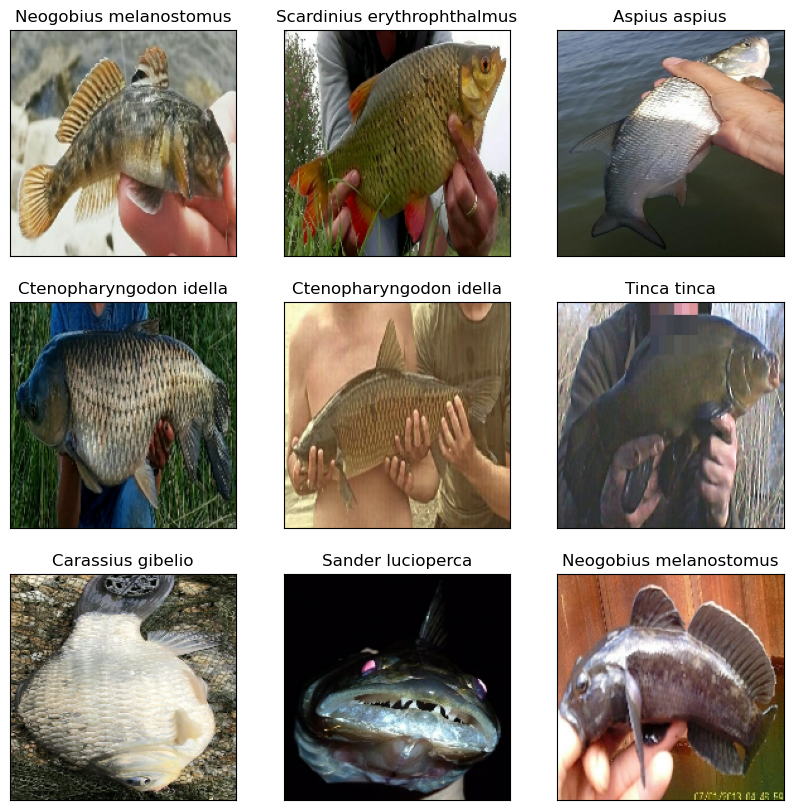

In [26]:
# testing using sample label - to try debug final evaluation
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(sample_imgs[i].astype("uint8")) #images[i].numpy().astype("uint8"))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(class_names[sample_labels[i]])
plt.show()

## My model (based on TM358 EMA model)

### Data augmentation

In [27]:
# Creating the normalisation layer
norm_layer = layers.Normalization(input_shape=(image_size))
norm_layer.adapt(train_dataset.map(lambda x, y: x))

In [28]:
# Creating an augmented subset
data_augmentation = tf.keras.Sequential([
#layers.RandomRotation(0.2),
#layers.RandomZoom(height_factor=0.1),
layers.RandomFlip(mode='horizontal')
])

aug_train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y),
num_parallel_calls=tf.data.AUTOTUNE)
aug_train_dataset = aug_train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

### Model creation

In [29]:
# Define function to create model and compile
def build_model():
    model = Sequential([
        #norm_layer, # to normalise data - making training freeze
        Conv2D(filters=16, kernel_size=(3,3), padding='same',
        input_shape=image_size, activation='relu'),
        Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
        Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.5),
        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',#(learning_rate=0.005),
        loss='sparse_categorical_crossentropy',#sparse_categorical_crossentropy
        metrics=['accuracy']
        )
    return model

In [30]:
# Build the model using the build_model function
model=build_model()

In [31]:
# Show a summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 90, 90, 16)        2320      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 90, 90, 32)       

### Train the model

In [32]:
# Train the model
#with tf.device("/device:GPU:0"):
hist=model.fit(
aug_train_dataset, 
validation_data=val_dataset, 
verbose=1,
epochs=20)

Epoch 1/20
188/188 [==============================] - 19s 81ms/step - loss: 3.2348 - accuracy: 0.0842 - val_loss: 3.0077 - val_accuracy: 0.1437
Epoch 2/20
188/188 [==============================] - 14s 76ms/step - loss: 2.9087 - accuracy: 0.1587 - val_loss: 2.8620 - val_accuracy: 0.1718
Epoch 3/20
188/188 [==============================] - 15s 77ms/step - loss: 2.7262 - accuracy: 0.2020 - val_loss: 2.5740 - val_accuracy: 0.2560
Epoch 4/20
188/188 [==============================] - 15s 78ms/step - loss: 2.5247 - accuracy: 0.2721 - val_loss: 2.5330 - val_accuracy: 0.2747
Epoch 5/20
188/188 [==============================] - 15s 77ms/step - loss: 2.3936 - accuracy: 0.3060 - val_loss: 2.4150 - val_accuracy: 0.2975
Epoch 6/20
188/188 [==============================] - 15s 77ms/step - loss: 2.2141 - accuracy: 0.3453 - val_loss: 2.1629 - val_accuracy: 0.3690
Epoch 7/20
188/188 [==============================] - 14s 76ms/step - loss: 2.0629 - accuracy: 0.3839 - val_loss: 2.1659 - val_accuracy:

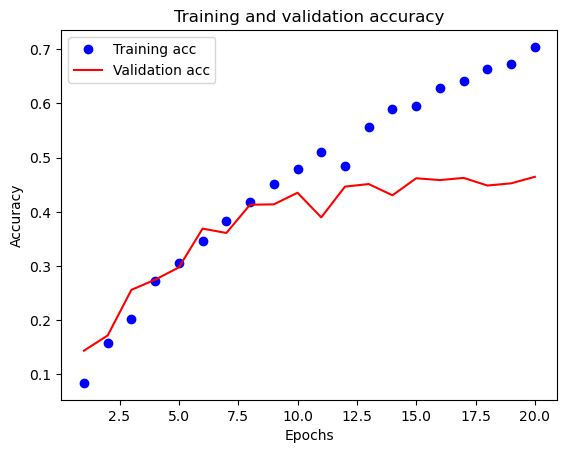

Text(0, 0.5, 'Loss')

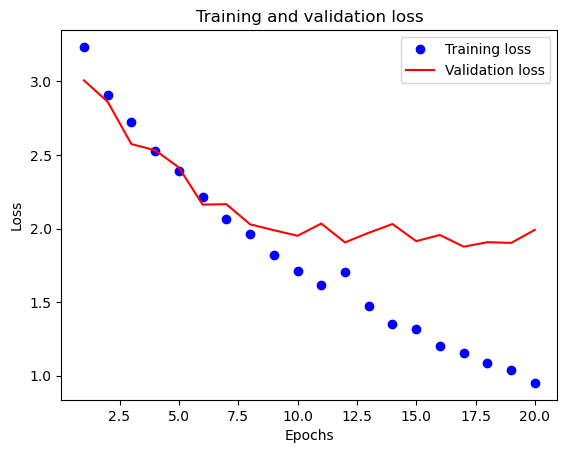

In [33]:
# Plotting training loss and accuracy as well as validation loss and accuracy over the number of epochs
hist_dict = hist.history

# obtain the accuracy and loss of the training set and verification set in the returned
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(train_acc)+1)
plt.plot(epochs, train_acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend() # show legend 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
plt.figure()

plt.plot(epochs, train_loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

### Evaluating the model (based on code from TM358)

In [34]:
model.evaluate(test_dataset, return_dict=True)

234/234 [==============================] - 7s 29ms/step - loss: 0.7446 - accuracy: 0.8025


{'loss': 0.7446087002754211, 'accuracy': 0.8024592399597168}

In [35]:
test_predictions=model.predict(test_dataset)
test_predictions.shape

(7482, 30)

In [36]:
predict_labels = np.argmax(test_predictions, axis=1)
predict_labels.shape

(7482,)

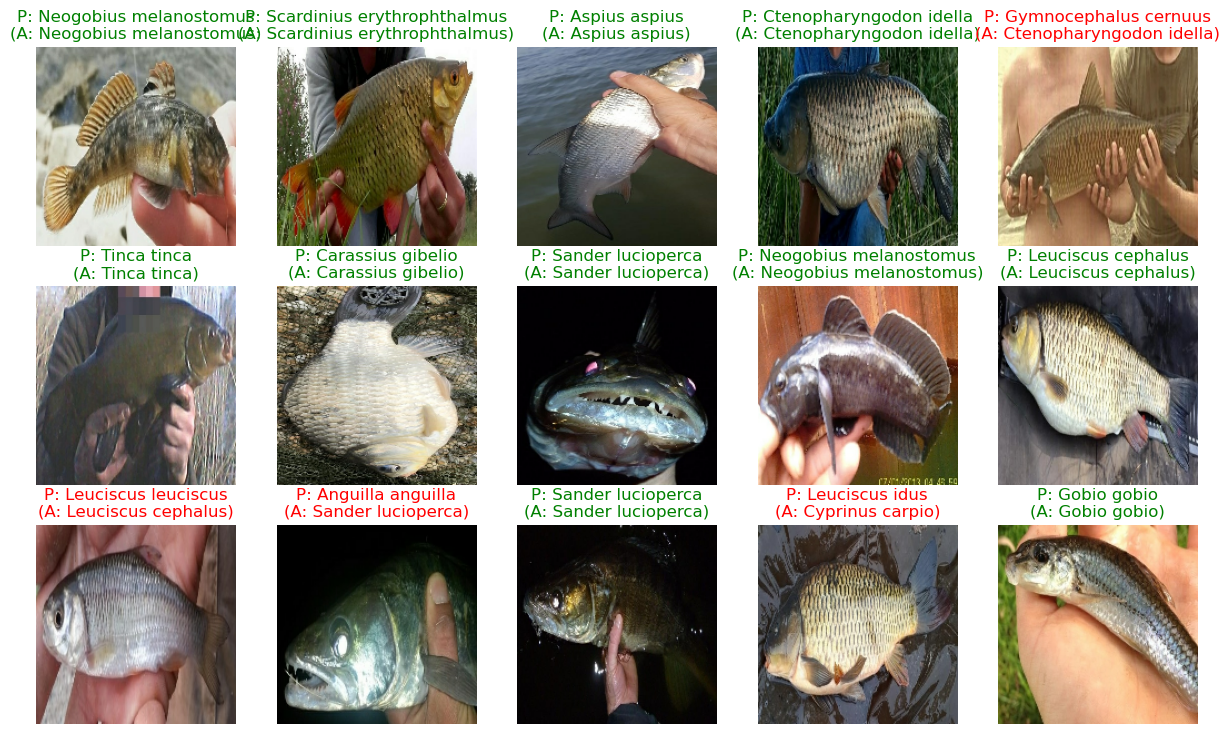

In [37]:
sample_predictions = model(sample_imgs)
# View the true and predicted labels of sample images
plt.figure(figsize=(15,15))
for i in range(15):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_imgs[i].astype("uint8"))
    #plt.imshow(sample_imgs[i])
    p_class = np.argmax(sample_predictions[i])
    a_class = sample_labels[i]# a_class = np.argmax(sample_labels[i]) ##np.argmax was the problem?!?
    #plt.title(f"P: {class_names[p_class]}\n(A: {class_names[a_class]})",
    plt.title(f"P: {class_names[p_class]}\n(A: {class_names[a_class]})",# class_names[a_class]
    color=("green" if p_class == a_class else "red"))
    plt.axis("off")
plt.show()